In [ ]:
import torch
import torch.nn as nn
import torchvision 
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.optim as optim 
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image 

In [ ]:
latent_size=100
hidden_size=100
epochs=200
img_size=28*28
batch_size=100
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
compose=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])

In [ ]:
mnist_train = dsets.MNIST(root = '../data/',
                      train=True,
                      transform = compose,
                      download=True)

mnist_test = dsets.MNIST(root = '../data/',
                         train=False,
                         transform=compose)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
train_data=dsets.MNIST(root='../data/',train=True,transform=compose,download=True)
test_data=dsets.MNIST(root='../data/',train=False,transform=compose)


0


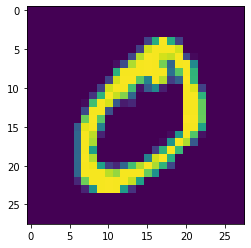

In [ ]:
#train_data=[(img,label),(img,label),....]
plt.imshow(train_data[1][0].squeeze(0))
print(train_data[1][1])

In [ ]:
train_loader=torch.utils.data.DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_data,batch_size=10,shuffle=False)

In [ ]:
class Generator(nn.Module):
    def __init__(self,latent_size,hidden_size,img_size):
        super(Generator,self).__init__()
        self.layer1=nn.Linear(in_features=latent_size,out_features=hidden_size)
        self.layer2=nn.Linear(in_features=hidden_size,out_features=hidden_size)
        self.layer3=nn.Linear(in_features=hidden_size,out_features=img_size)
        
        self.relu=nn.ReLU()
        self.tanh=nn.Tanh()
    
    def forward(self,x):
        out=self.relu(self.layer1(x))
        out=self.relu(self.layer2(out))
        out=self.layer3(out)
        out=self.tanh(out)
        
        return out
    

class Discriminator(nn.Module):
    def __init__(self,img_size,hidden_size):
        super(Discriminator,self).__init__()
        self.layer1=nn.Linear(in_features=img_size,out_features=hidden_size)
        self.layer2=nn.Linear(in_features=hidden_size,out_features=hidden_size)
        self.layer3=nn.Linear(in_features=hidden_size,out_features=1)
        
        self.relu=nn.ReLU()
        self.sigmoid=nn.Sigmoid()
        
    def forward(self,x):
        out=self.relu(self.layer1(x))
        out=self.relu(self.layer2(out))
        out=self.layer3(out)
        out=self.sigmoid(out)
        
        return out
    
G=Generator(latent_size,hidden_size,img_size).to(device)
D=Discriminator(img_size,hidden_size).to(device)

In [ ]:
#binary cross-entropy Loss: -[tlog(p)+(1-t)log(1-p)]
criterion=nn.BCELoss()
D_optim=torch.optim.Adam(D.parameters(),lr=0.0002)
G_optim=torch.optim.Adam(G.parameters(),lr=0.0002)

In [ ]:
total_step=len(train_loader)

for epoch in range(epochs):
    for i,(imgs,_) in enumerate(train_loader):
        imgs=imgs.reshape(batch_size,28*28).to(device) #28*28=784
        z=torch.randn(batch_size,latent_size).to(device)
        
        real_labels=torch.ones(batch_size,1).to(device)
        fake_labels=torch.zeros(batch_size,1).to(device)
        
# train a Discriminator 

        D_real_out=D(imgs)
        D_real_loss=criterion(D_real_out,real_labels) #-y*log(y')
        real_score = D_real_out
        
        fake_imgs = G(z)
        D_fake_out=D(fake_imgs)
        D_fake_loss=criterion(D_fake_out,fake_labels) #-(1)*log(1-y')
        fake_score = D_fake_out
        
        D_loss=D_real_loss + D_fake_loss
        
        D_optim.zero_grad()  #to reset the gradients of model parameters
        D_loss.backward()    # to deposit the gradients of the loss w.r.t. each parameter.
        D_optim.step()  # to adjust the parameters by the gradients collected in the backward pass.
        
# train a generator

        z=torch.randn(batch_size,latent_size).to(device)
        fake_imgs = G(z)
        D_fake_out=D(fake_imgs)
        
        
        G_loss=criterion(D_fake_out,real_labels) #y=1,y'=D(G(z)) >>-log(D(G(z)))
        
        G_optim.zero_grad()  
        G_loss.backward()    
        G_optim.step() 
        
        
        if((i+1)%200==0):
          print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, epochs, i+1, total_step, D_loss.item(), G_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        

Epoch [0/200], Step [200/600], d_loss: 0.2609, g_loss: 1.9310, D(x): 0.96, D(G(z)): 0.19
Epoch [0/200], Step [400/600], d_loss: 0.1701, g_loss: 2.3715, D(x): 0.98, D(G(z)): 0.14
Epoch [0/200], Step [600/600], d_loss: 0.2483, g_loss: 2.4960, D(x): 0.93, D(G(z)): 0.15
Epoch [1/200], Step [200/600], d_loss: 0.0715, g_loss: 3.8379, D(x): 0.98, D(G(z)): 0.04
Epoch [1/200], Step [400/600], d_loss: 0.0476, g_loss: 4.7595, D(x): 0.98, D(G(z)): 0.03
Epoch [1/200], Step [600/600], d_loss: 0.6917, g_loss: 1.9798, D(x): 0.84, D(G(z)): 0.36
Epoch [2/200], Step [200/600], d_loss: 0.4543, g_loss: 1.9699, D(x): 0.86, D(G(z)): 0.21
Epoch [2/200], Step [400/600], d_loss: 0.1920, g_loss: 2.5951, D(x): 0.93, D(G(z)): 0.10
Epoch [2/200], Step [600/600], d_loss: 0.9568, g_loss: 1.7244, D(x): 0.77, D(G(z)): 0.40
Epoch [3/200], Step [200/600], d_loss: 0.1542, g_loss: 3.9103, D(x): 0.94, D(G(z)): 0.06
Epoch [3/200], Step [400/600], d_loss: 1.4302, g_loss: 1.5968, D(x): 0.51, D(G(z)): 0.26
Epoch [3/200], Step [